In [144]:

import cv2 as cv
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from random import *
import math
import os
from numpy.fft import fft2, ifft2
#from scipy.misc import imread,imresize
import matplotlib.pyplot as plt
from operator import itemgetter, attrgetter
import queue
%matplotlib inline


## 1 The Fuzzy Scanner

In [145]:
def signaltonoise(a, axis=0, ddof=0):
    b = np.asanyarray(a)
    a = b
    return np.where(a.std(axis=axis, ddof=ddof) == 0, 0, a.mean(axis)/(a.std(axis=axis, ddof=ddof)))

def wiener_kerenel(n,m,a=0.1,b =0.1,T=1):
    x, y = np.meshgrid(np.arange(n)-n/2,np.arange(m)-m/2)
    pi_ua_vb= np.pi*(x*a+y*b+0.0001)
    H= np.sin(pi_ua_vb)*np.exp(-1j*pi_ua_vb)*(T/(pi_ua_vb))
    return H
    
def plot_covoled(original, transformed, titles, which):
    fig, ax = plt.subplots(1, 1+len(transformed), figsize=(30, 10))
    fig.suptitle(which)
    ax[0].imshow(original, cmap="gray")
    ax[0].set_title(f"original")
    ax[0].axis('off')
    for i in range(len(transformed)):
        ax[1+i].imshow(transformed[i], cmap="gray")
        ax[1+i].set_title(titles[i])
        ax[1].axis('off')
        
def add_gaussian(img, mean, var):
    img = np.fft.fft2(img) + np.fft.fft2 (np.random.normal(mean, np.sqrt(var) , img.shape))
    img = np.fft.ifft2(img)
    img = img.real
    # plt.imshow(img, cmap='gray')
    return img
# plt.title("Gaussian Noise added with Variance 650")
# plt.show()
    
def wiener_filter(im,kernel,a=0.1,b =0.1,T=1):
    blur = np.fft.ifft2(np.fft.ifftshift(np.fft.fftshift(np.fft.fft2(im)) * kernel))
    return blur

def inverse_filter(im,kernel,a=0.1,b =0.1,T=1):
    fft = np.fft.fftshift(np.fft.fft2(im))
    unblur = np.fft.ifft(np.fft.ifftshift(fft/kernel))
    return unblur

# def winer_deconvolution(im,kernel,a=0.1,b =0.1,T=1):
#     deblur = np.fft.ifft2(np.fft.ifftshift((np.fft.fftshift(np.fft.fft2(im))) * 1/kernel*(np.abs(kernel)**2/((np.abs(kernel)**2)+1/signaltonoise(im)))))
#     return deblur



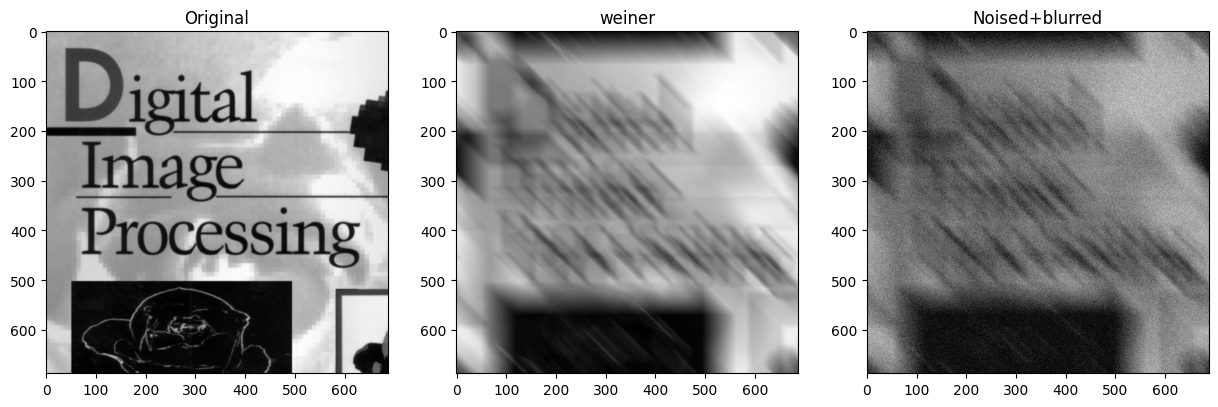

In [162]:
img = cv.imread("./../imgs/book.jpg")
Gray = cv.imread("./../imgs/book.jpg",0)
kernel = wiener_kerenel(Gray.shape[0],Gray.shape[1],0.1,0.1,1)
wiener_transform = wiener_filter(Gray,kernel)
noised = add_gaussian(wiener_transform,0,650)

fig, axs = plt.subplots(1,3,figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(Gray,cmap="gray")
plt.title("Original")
plt.subplot(1,3,2)
plt.imshow(np.abs(wiener_transform),'gray')
plt.title("weiner")
plt.subplot(1,3,3)
plt.imshow(np.abs(noised),'gray')
plt.title("Noised+blurred")
plt.show()



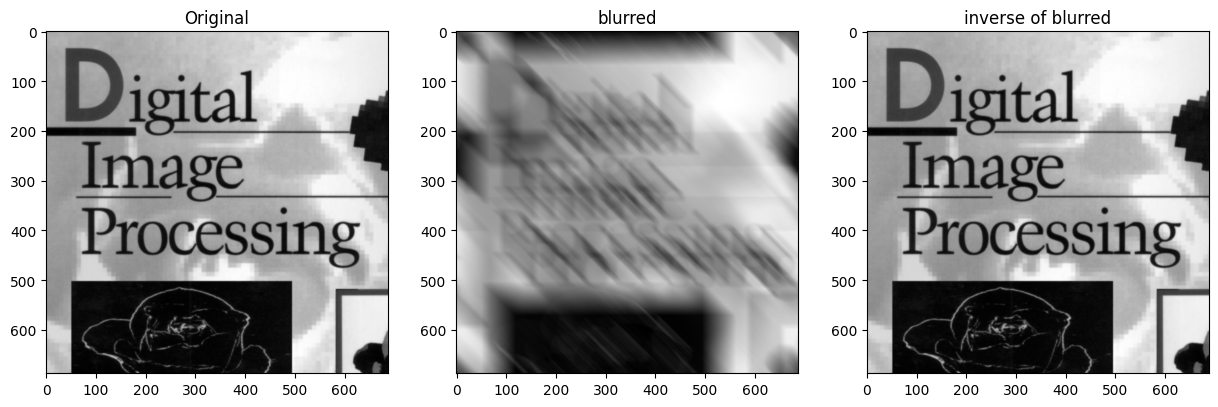

In [166]:
inverse = wiener_filter( wiener_transform,1/kernel)
fig, axs = plt.subplots(1,3,figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(Gray,cmap="gray")
plt.title("Original")
plt.subplot(1,3,2)
plt.imshow(np.abs(wiener_transform),'gray')
plt.title("blurred")
plt.subplot(1,3,3)
plt.imshow(np.abs(inverse),'gray')
plt.title("inverse of blurred")
plt.show()

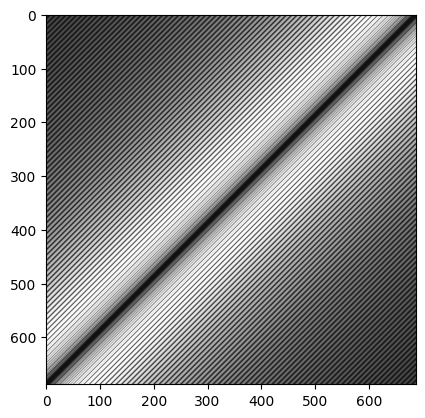

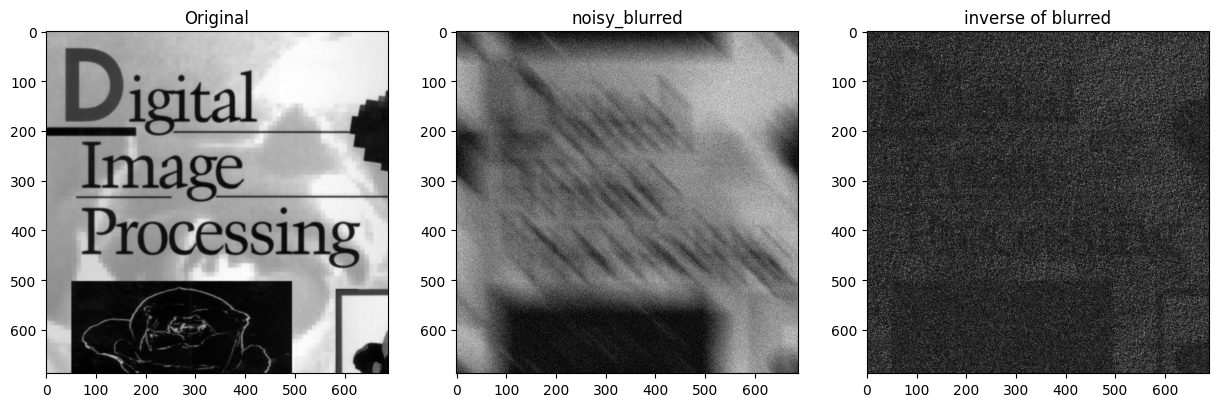

In [148]:
noised = add_gaussian(wiener_transform,0,650)
k = 0.001
kernel = np.conj(kernel)/(abs(kernel)**2 + k)
plt.imshow(np.abs(kernel),cmap = 'gray')
inverse = wiener_filter(noised,kernel)
fig, axs = plt.subplots(1,3,figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(Gray,cmap="gray")
plt.title("Original")
plt.subplot(1,3,2)
plt.imshow(np.abs(noised),'gray')
plt.title("noisy_blurred")
plt.subplot(1,3,3)
plt.imshow(np.abs(inverse),'gray')
plt.title("inverse of blurred")
plt.show()

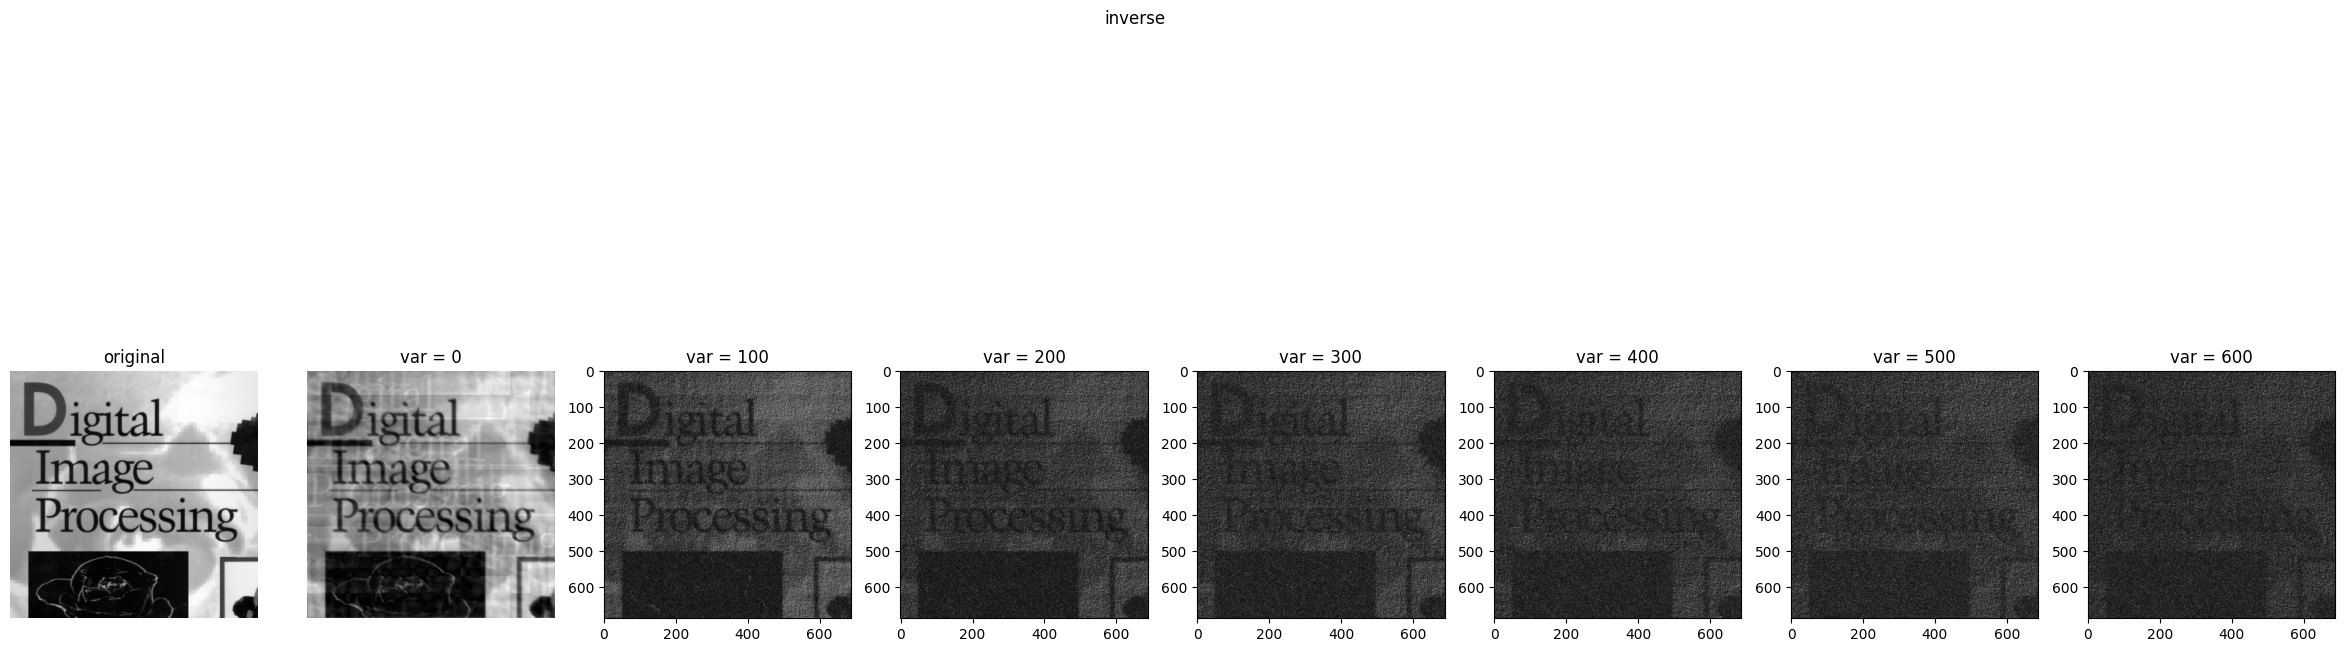

In [149]:
unblur_images =[]
titile =[]
for i in range(0,700,100):
    noised_wiener = add_gaussian(wiener_transform,0,i)
    inverse = wiener_filter( noised_wiener,kernel)
    unblur_images.append(np.abs(inverse))
    titile.append(f"var = {i}")
    
plot_covoled(Gray, unblur_images,titile, "inverse")

curtain noise is there on the images which goes on increaing with the increase in variance

Performance of Wiener Filter:

As we decrease the variance(), the  of the image, we observe that the noise added is lesser, and hence, the performance of the Wiener Deconvolution filter is better at restoring the degraded image.

As we keep decreasing the  of Weiner Filter, we observe that the Wiener Deconvolution filter tends to the Inverse Degradation Filter, and hence, if we keep on decreasing , we observe a performance that is more and more closer to the Inverse Degradation Filter, and hence, the better value.

 interpreted as the reciprocal of the signal-to-noise ratio.

## 2 Data transfer

### Huffman Encoding

In [150]:
class Node:
	def __init__(self):
		self.prob = None
		self.code = None
		self.data = None
		self.left = None
		self.right = None 	# the color (the bin value) is only required in the leaves
	def __lt__(self, other):
		if (self.prob < other.prob):		# define rich comparison methods for sorting in the priority queue
			return 1
		else:
			return 0
	def __ge__(self, other):
		if (self.prob > other.prob):
			return 1
		else:
			return 0
def rgb2gray(img):
	gray_img = np.rint(img[:,:,0]*0.2989 + img[:,:,1]*0.5870 + img[:,:,2]*0.1140)
	gray_img = gray_img.astype(int)
	return gray_img

def get2smallest(data):			# can be used instead of inbuilt function get(). was not used in  implementation
    first = second = 1;
    fid=sid=0
    for idx,element in enumerate(data):
        if (element < first):
            second = first
            sid = fid
            first = element
            fid = idx
        elif (element < second and element != first):
            second = element
    return fid,first,sid,second
    
def tree(probabilities):
	prq = queue.PriorityQueue()
	for color,probability in enumerate(probabilities):
		leaf = Node()
		leaf.data = color
		leaf.prob = probability
		prq.put(leaf)

	while (prq.qsize()>1):
		newnode = Node()		# create new node
		l = prq.get()
		r = prq.get()			# get the smalles probs in the leaves
						# remove the smallest two leaves
		newnode.left = l 		# left is smaller
		newnode.right = r
		newprob = l.prob+r.prob	# the new prob in the new node must be the sum of the other two
		newnode.prob = newprob
		prq.put(newnode)	# new node is inserted as a leaf, replacing the other two 
	return prq.get()		# return the root node - tree is complete

def huffman_traversal(root_node,tmp_array,f):		# traversal of the tree to generate codes
	if (root_node.left is not None):
		tmp_array[huffman_traversal.count] = 1
		huffman_traversal.count+=1
		huffman_traversal(root_node.left,tmp_array,f)
		huffman_traversal.count-=1
	if (root_node.right is not None):
		tmp_array[huffman_traversal.count] = 0
		huffman_traversal.count+=1
		huffman_traversal(root_node.right,tmp_array,f)
		huffman_traversal.count-=1
	else:
		huffman_traversal.output_bits[root_node.data] = huffman_traversal.count		#count the number of bits for each color
		bitstream = ''.join(str(cell) for cell in tmp_array[1:huffman_traversal.count]) 
		color = str(root_node.data)
		wr_str = color+' '+ bitstream+'\n'
		f.write(wr_str)		# write the color and the code to a file
	return


In [151]:

# Read an bmp image into a numpy array
img = cv.imread("./../imgs/book.jpg")
scale_percent = 10

#calculate the 50 percent of original dimensions
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)

# dsize
dsize = (width, height)
img = cv.resize(img,dsize)		# resize to 10% (not strictly necessary - done for faster computation)

# convert to grayscale
gray_img = rgb2gray(img)

# compute histogram of pixels
hist = np.bincount(gray_img.ravel(),minlength=256)

probabilities = hist/np.sum(hist)		# a priori probabilities from frequencies

root_node = tree(probabilities)			# create the tree using the probs.
tmp_array = np.ones([64],dtype=int)
huffman_traversal.output_bits = np.empty(256,dtype=int) 
huffman_traversal.count = 0
f = open('codes.txt','w')
huffman_traversal(root_node,tmp_array,f)		# traverse the tree and write the codes

input_bits = img.shape[0]*img.shape[1]*8	# calculate number of bits in grayscale 
compression = (1-np.sum(huffman_traversal.output_bits*hist)/input_bits)*100	# compression rate
print('Compression rate is ',compression,' percent')

Compression rate is  7.9125216262975755  percent


In [152]:
def LZW_encode(img):
    dictionary = {}
    for i in range(256):
        dictionary[chr(i)] = i
    w = ""
    result = []
    dict_size = 256
    for c in img:
        wc = w + chr(c)
        if wc in dictionary:
            w = wc
        else:
            result.append(dictionary[w])
            dictionary[wc] = dict_size
            dict_size += 1
            w = chr(c)
    if w:
        result.append(dictionary[w])
    return result

def LZW_decode(data):
    dictionary = {}
    for i in range(256):
        dictionary[i] = chr(i)
    w = chr(data.pop(0))
    result = w
    for k in data:
        if k in dictionary:
            entry = dictionary[k]
        elif k == len(dictionary):
            entry = w + w[0]
        else:
            raise ValueError('Bad compressed k: %s' % k)
        result += entry
        dictionary[len(dictionary)] = w + entry[0]
        w = entry
    return result




----------- Image -----------



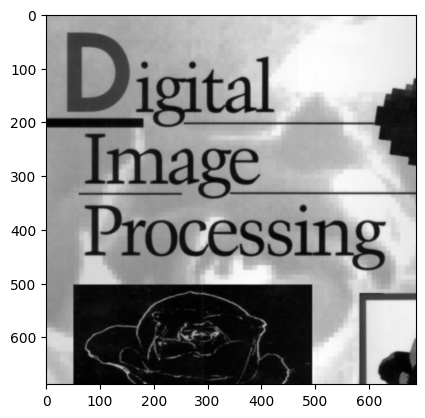

----------- ***** -----------

rate ofcompression : 85.57212090995132


In [153]:
image_tp_4 = cv.imread("./../imgs/book.jpg", 0)
width,height = image_tp_4.shape

print("\n----------- Image -----------\n")
plt.imshow(image_tp_4,cmap="gray")
plt.show()
print("----------- ***** -----------\n")


string_image = image_tp_4.flatten().tolist()

compressed_image = LZW_encode(string_image)


# --- Taux de compression
compression_rate = (1-(len(compressed_image)/2)/len(string_image))*100
print(f"rate ofcompression : {compression_rate}")



In [154]:
def RLE_compress(string_image):
    compressed_image = []
    count = 1
    for i in range(len(string_image)-1):
        if string_image[i] == string_image[i+1]:
            count += 1
        else:
            compressed_image.append(string_image[i])
            compressed_image.append(count)
            count = 1
    compressed_image.append(string_image[-1])
    compressed_image.append(count)
    return compressed_image

def RLE_decompress(compressed_image):
    decompressed_image = []
    for i in range(0,len(compressed_image),2):
        decompressed_image += [compressed_image[i]] * compressed_image[i+1]
    return decompressed_image

In [155]:
#run length encoding compression of an image code
img = cv.imread("./../imgs/book.jpg")
string_image = image_tp_4.flatten().tolist()

compressed_image = RLE_compress(string_image)
compression_rate = (1-(len(compressed_image)/2)/len(string_image))*100
print(f"rate of compression : {compression_rate}")



rate of compression : 32.02554590319091


In [156]:
#  coefficient quantization matrix
#  You can decide this by yourself.
quantization = [[5, 5, 5, 5, 5, 5, 5, 5],
                [5, 5, 5, 5, 5, 5, 5, 5],
                [5, 5, 5, 5, 5, 5, 5, 5],
                [5, 5, 5, 5, 5, 5, 5, 5],
                [5, 5, 5, 5, 5, 5, 5, 5],
                [5, 5, 5, 5, 5, 5, 5, 5],
                [5, 5, 5, 5, 5, 5, 5, 5],
                [5, 5, 5, 5, 5, 5, 5, 5]]


def dct(img):
    img_data = img.astype(float)
    m, n = img_data.shape
    img_dct = np.zeros(img.shape)
    x_batchsize = int(m/8)
    y_batchsize = int(n/8)

    for i in range(0,x_batchsize):
        for j in range(0,y_batchsize):
            window_x_s = i * 8
            window_x = (i+1) * 8
            window_y_s = j * 8
            window_y = (j+1) * 8
            img_dct[window_x_s:window_x, window_y_s:window_y] = cv.dct(img_data[window_x_s:window_x,window_y_s:window_y]) / quantization
    return img_dct



def idct(img_dct):
    img_re = np.zeros(img_dct.shape)
    m,n = img_dct.shape
    x_batchsize = int(m/8)
    y_batchsize = int(n/8)
    for i in range(0,x_batchsize):
        for j in range(0,y_batchsize):
            window_x_s = i * 8
            window_x = (i+1) * 8
            window_y_s = j * 8
            window_y = (j+1) * 8
            img_re[window_x_s:window_x,window_y_s:window_y] = cv.idct(img_dct[window_x_s:window_x, window_y_s:window_y]) * quantization
    return img_re


def NumPixels(f):
    '''
     n = NumPixels(f) returns the total number of elements in the array f.
     
     For example,
       NumPixels( np.ones((5,4)) )
     returns the value 20.
    '''
    return np.prod(np.shape(f))


(([], []), ([], []))

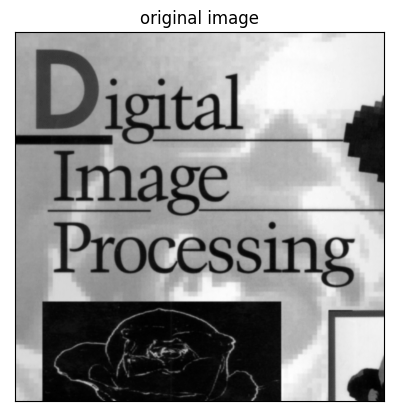

In [157]:
img = cv.imread("./../imgs/book.jpg", 0)
    # DCT
img_dct = dct(img)

    # IDCT
img_re = idct(img_dct)

plt.imshow(img, 'gray')
plt.title('original image')
plt.xticks([]), plt.yticks([])


#

(([], []), ([], []))

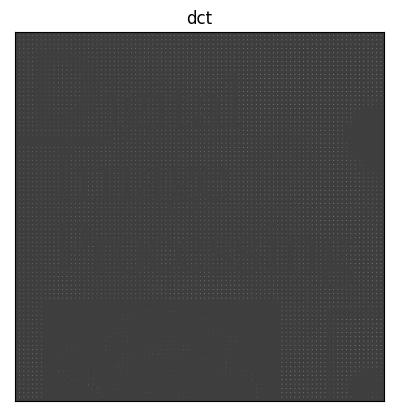

In [158]:
plt.imshow(img_dct, 'gray')
plt.title('dct')
plt.xticks([]), plt.yticks([])


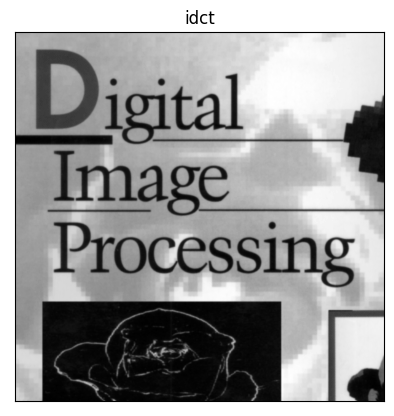

In [159]:
plt.imshow(img_re, 'gray')
plt.title('idct') #Compression ratio is nearly equal to 1 KB
plt.xticks([]), plt.yticks([])
plt.show()

In [160]:
compression_rate = NumPixels(img) / NumPixels(img_dct)
print(f"rate of compression : {compression_rate}")

rate of compression : 1.0



 RLE compression is good 
- It is easy to implement
- It is a good alternative for a complex compression algorithm
- Fast to execute


drawback 
- It cannot achievethe high compression ratios as compared to another advanced compression methods

- - - - 

Huffman
- It is easy to implement
- Produce a lossless compression of images
- Huffman compression is a variable length type of
compression technique. 
- In Huffman, the coding
redundancy can be eliminated by assigning the codes
in better way

drawbacks
- Relatively slow
- Depends upon statistical model of data.
- Decoding is difficult due to different code lengths.

- - - - 

LZW compression
- LZW (Lempel- Ziv- Welch) is a dictionary based coding and lossless.
- Dictionary based coding can be static or dynamic. 
- In
static dictionary coding, dictionary is fixed during the
encoding and decoding process.
-  In dynamic dictionary
coding, the dictionary is updated on fly. 
- LZW is widely
used in computer industry and is implemented as
compress command on UNIX.


drawbacks 
- Files that do not contain any repetitive data at all cannot be compressed much.

- The method is good at text files but not as good at other types of files.

- The amount of storage needed is indeterminate as it depends on the total length of all the strings.

- - - - 

DCT 
- So the DCT possesses several traits that make it an effective tool for image compression. 
- The transformation is orthogonal (inverse is transpose and energy is preserved), fast algorithms can be used for computation
- the output for (near) constant matrices generally consists of a large number of (near) zero values.

drawbacks
- There is one major disadvantage of the DCT. While the input from preprocessed 8 x 8 blocks are integer-valued, the output values are typically real-valued. Thus we need a quantization step to make some decisions about the values in each DCT block and produce output that is interger-valued.